In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any, List

In [2]:
# --- 1. CONFIGURATION ---
INPUT_FILE = "final/smol_1b_exp3_final_results_with_logprobs_subset.json" # Your saved inference results
OUTPUT_PLOT = "smol1b_plot.png"


Plot saved successfully as smol1b_plot.png


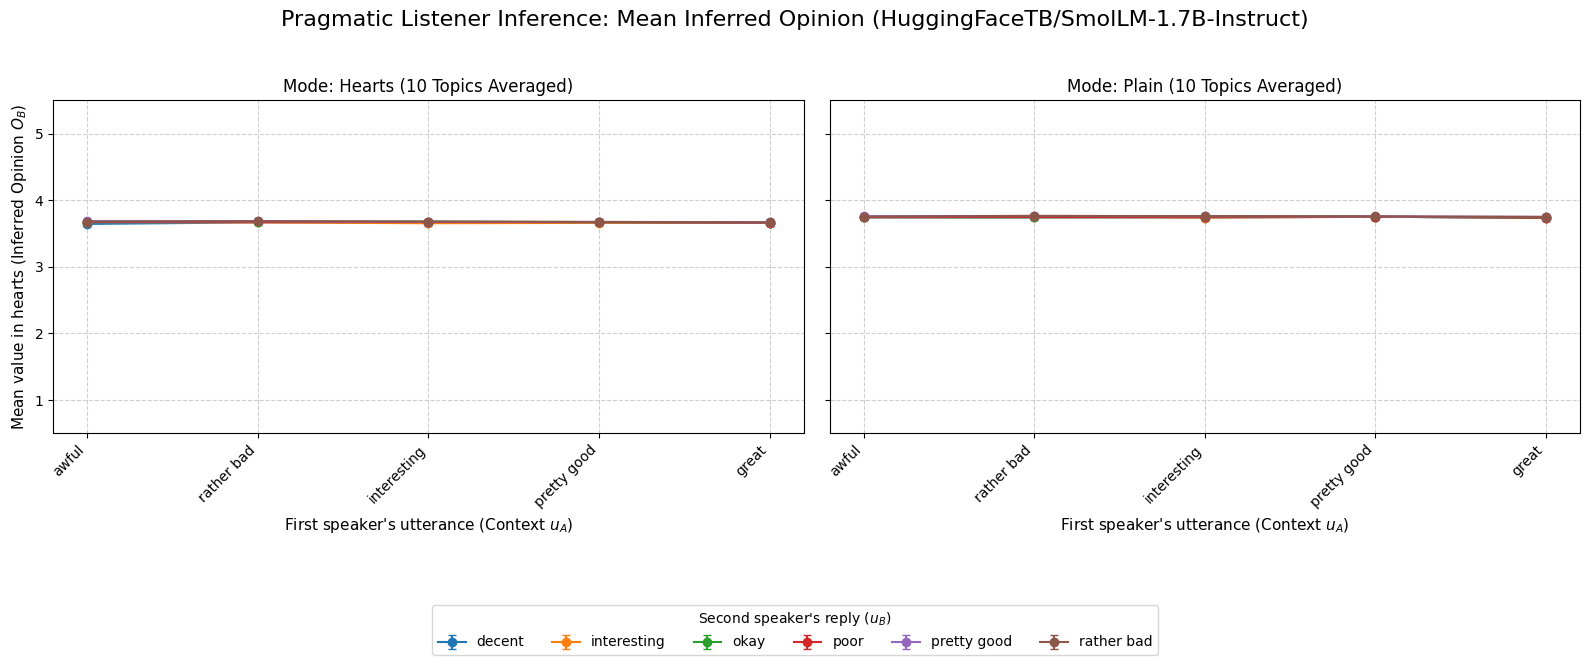

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any, List


# Adjective ranks based on the 1-5 scale (for X-axis plotting)
ADJECTIVE_RANKS = {
    'terrible': 1, 'awful': 1,
    'poor': 2, 'rather bad': 2,
    'okay': 3, 'interesting': 3,
    'decent': 4, 'pretty good': 4,
    'amazing': 5, 'great': 5
}

# --- 2. DATA PROCESSING AND METRIC CALCULATION ---

def calculate_mean_opinion(data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Transforms raw log probabilities into mean inferred opinion (Expected Value)
    and prepares the data for plotting.
    """
    processed_data = []
    scores = np.arange(1, 6) # The heart scores (1, 2, 3, 4, 5)

    for row in data:
        # Check for both top_10_log_probs (from vLLM) and the old log_probability_distribution name
        log_probs_source = row.get("top_10_log_probs") or row.get("log_probability_distribution")

        # Skip if data is incomplete or corrupted
        if not log_probs_source or not row.get("u_a_word") or row.get("inferred_answer") in ["TIMEOUT", "ERROR", "FAIL"]:
            continue

        # --- STEP A: Convert log_probs to normalized Probability Distribution (Pi) ---
        target_log_probs = []
        
        for i in scores:
            score_str = str(i)
            # Account for both '1' and ' 1' token representations
            log_p = log_probs_source.get(score_str) or log_probs_source.get(f' {score_str}')
            
            # If log_p is missing, assign a negligible log-prob (-20.0)
            target_log_probs.append(log_p if log_p is not None else -20.0)

        target_log_probs = np.array(target_log_probs)
        
        # Convert to probabilities (P = exp(log P))
        probabilities = np.exp(target_log_probs)
        
        # Normalize the probabilities
        sum_p = probabilities.sum()
        if sum_p == 0:
             continue 
             
        normalized_probabilities = probabilities / sum_p
        
        # --- STEP B: Calculate Mean Inferred Opinion (Expected Value) ---
        # Mean = Sum(i * Pi) for i = 1 to 5
        mean_opinion = np.sum(scores * normalized_probabilities)

        # --- STEP C: Prepare Row for DataFrame ---
        
        # Map u_a_word (X-axis) to its rank (numeric X-axis position)
        u_a_rank = ADJECTIVE_RANKS.get(row['u_a_word'], np.nan)
        
        processed_data.append({
            'u_a_rank': u_a_rank,
            'u_a_word': row['u_a_word'], 
            'u_b_word': row['u_b_word'], 
            'mean_inferred_opinion': mean_opinion, 
            'mode': row['mode'],
            'topic': row['topic'] 
        })

    # Create DataFrame and drop any rows where the U_A adjective was unmappable
    df = pd.DataFrame(processed_data).dropna(subset=['u_a_rank'])
    
    # 4. Aggregate: Group data for plotting by averaging across all profiles/topics.
    agg_df = df.groupby(['mode', 'u_a_rank', 'u_b_word']).agg(
        mean_opinion=('mean_inferred_opinion', 'mean'),
        sem_opinion=('mean_inferred_opinion', lambda x: np.std(x) / np.sqrt(len(x))),
        num_topics=('topic', 'nunique')
    ).reset_index()

    return agg_df, df

# --- 3. PLOTTING FUNCTION (Replicating Figure 11 Structure) ---

def plot_exp3_results(agg_df: pd.DataFrame, raw_df: pd.DataFrame, adj_ranks: Dict[str, int]) -> None:
    """Generates the Opinion Inference Values plot."""
    
    # Create one figure with two subplots: one for Plain and one for Hearts mode
    # Check if we have two modes; if not, use a single subplot layout
    modes = agg_df['mode'].unique()
    if len(modes) == 1:
        fig, ax_list = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
        axes = [ax_list] # Wrap single axis in a list
    else:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    fig.suptitle("Pragmatic Listener Inference: Mean Inferred Opinion (HuggingFaceTB/SmolLM-1.7B-Instruct)", fontsize=16)
    
    # Define the order of the X-axis labels
    rank_to_word = {rank: word for word, rank in adj_ranks.items() if rank in agg_df['u_a_rank'].unique()}
    x_labels = [rank_to_word.get(r, str(r)) for r in sorted(agg_df['u_a_rank'].unique())]
    
    # Total unique topics used in the ENTIRE experiment (from the raw data)
    total_unique_topics = raw_df['topic'].nunique()
    
    # Iterate over modes (Plain and Hearts)
    for i, mode in enumerate(modes):
        ax = axes[i] if len(modes) > 1 else axes # Select the correct axis
        subset_mode = agg_df[agg_df['mode'] == mode]
        
        # Set number of topics for the title
        num_topics = total_unique_topics
        
        for u_b_word in sorted(subset_mode['u_b_word'].unique()):
            subset = subset_mode[subset_mode['u_b_word'] == u_b_word]
            subset = subset.sort_values('u_a_rank')
            
            ax.errorbar(
                subset['u_a_rank'], 
                subset['mean_opinion'],
                yerr=subset['sem_opinion'], 
                label=u_b_word, 
                marker='o',
                capsize=3
            )

        # Set axis properties
        ax.set_xticks(sorted(agg_df['u_a_rank'].unique()))
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        
        ax.set_xlabel("First speaker's utterance (Context $u_A$)", fontsize=11)
        if i == 0 or len(modes) == 1: # Only label Y-axis once (on the left plot)
             ax.set_ylabel("Mean value in hearts (Inferred Opinion $O_B$)", fontsize=11)
        
        ax.set_title(f"Mode: {mode.capitalize()} ({num_topics} Topics Averaged)", fontsize=12)
        ax.set_ylim(0.5, 5.5) 
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # Place a single legend outside the plots
    # Get handles/labels from the first active axis
    if len(modes) > 1:
        handles, labels = axes[0].get_legend_handles_labels() 
    else:
        handles, labels = axes.get_legend_handles_labels()

    fig.legend(handles, labels, title="Second speaker's reply ($u_B$)", loc='upper center', ncol=len(agg_df['u_b_word'].unique()), bbox_to_anchor=(0.5, 0.0))

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.savefig(OUTPUT_PLOT)
    print(f"Plot saved successfully as {OUTPUT_PLOT}")


# --- 4. MAIN EXECUTION ---

if __name__ == "__main__":
    try:
        # 1. Load Data
        with open(INPUT_FILE, 'r') as f:
            raw_data = json.load(f)
        
        # 2. Calculate Metrics and Aggregate
        agg_df, raw_df_processed = calculate_mean_opinion(raw_data)
        
        # 3. Generate Plot
        plot_exp3_results(agg_df, raw_df_processed, ADJECTIVE_RANKS)
        
    except FileNotFoundError:
        print(f"Error: Input file '{INPUT_FILE}' not found. Please ensure the file is named {INPUT_FILE}.")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")


Plot saved successfully as smol1b_plot.png


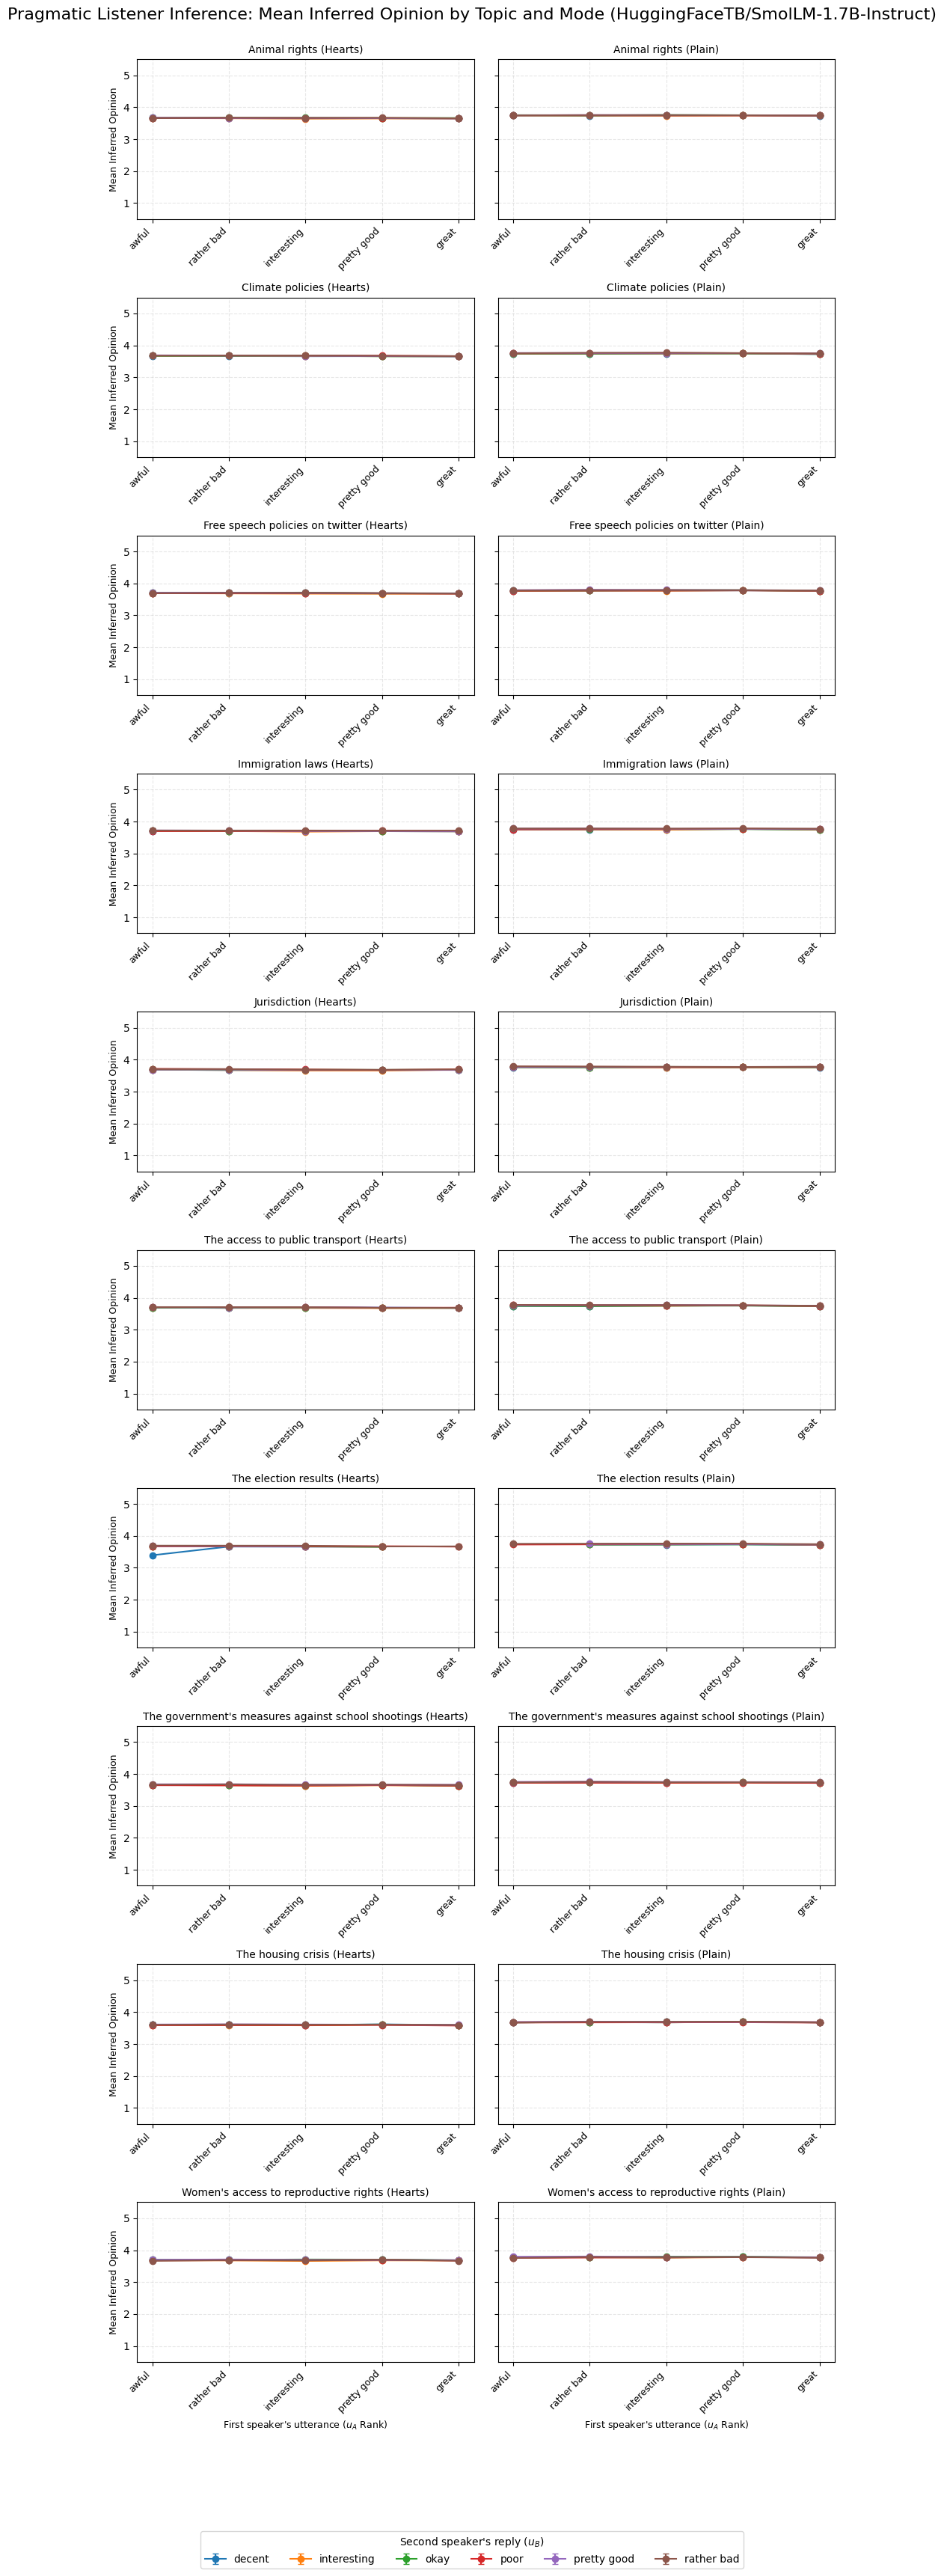

In [4]:
def calculate_mean_opinion(data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Transforms raw log probabilities into mean inferred opinion (Expected Value)
    and prepares the data for plotting.
    """
    processed_data = []
    scores = np.arange(1, 6) # The heart scores (1, 2, 3, 4, 5)

    for row in data:
        # Check for both top_10_log_probs (from vLLM) and the old log_probability_distribution name
        log_probs_source = row.get("top_10_log_probs") or row.get("log_probability_distribution")

        # Skip if data is incomplete or corrupted
        if not log_probs_source or not row.get("u_a_word") or row.get("inferred_answer") in ["TIMEOUT", "ERROR", "FAIL"]:
            continue

        # --- STEP A: Convert log_probs to normalized Probability Distribution (Pi) ---
        target_log_probs = []
        
        for i in scores:
            score_str = str(i)
            # Account for both '1' and ' 1' token representations
            log_p = log_probs_source.get(score_str) or log_probs_source.get(f' {score_str}')
            
            # If log_p is missing, assign a negligible log-prob (-20.0)
            target_log_probs.append(log_p if log_p is not None else -20.0)

        target_log_probs = np.array(target_log_probs)
        
        # Convert to probabilities (P = exp(log P))
        probabilities = np.exp(target_log_probs)
        
        # Normalize the probabilities
        sum_p = probabilities.sum()
        if sum_p == 0:
             continue 
             
        normalized_probabilities = probabilities / sum_p
        
        # --- STEP B: Calculate Mean Inferred Opinion (Expected Value) ---
        # Mean = Sum(i * Pi) for i = 1 to 5
        mean_opinion = np.sum(scores * normalized_probabilities)

        # --- STEP C: Prepare Row for DataFrame ---
        
        # Map u_a_word (X-axis) to its rank (numeric X-axis position)
        u_a_rank = ADJECTIVE_RANKS.get(row['u_a_word'], np.nan)
        
        processed_data.append({
            'u_a_rank': u_a_rank,
            'u_a_word': row['u_a_word'], 
            'u_b_word': row['u_b_word'], 
            'mean_inferred_opinion': mean_opinion, 
            'mode': row['mode'],
            'topic': row['topic'] 
        })

    # Create DataFrame and drop any rows where the U_A adjective was unmappable
    df = pd.DataFrame(processed_data).dropna(subset=['u_a_rank'])
    
    # 4. Aggregate: Group data for plotting by averaging across profiles/topics.
    # CRUCIAL: Group by 'topic' as well to keep them separate
    agg_df = df.groupby(['mode', 'topic', 'u_a_rank', 'u_b_word']).agg(
        mean_opinion=('mean_inferred_opinion', 'mean'),
        sem_opinion=('mean_inferred_opinion', lambda x: np.std(x) / np.sqrt(len(x))),
    ).reset_index()

    return agg_df, df

# --- 3. PLOTTING FUNCTION (Generates a 5x2 grid) ---

def plot_exp3_results(agg_df: pd.DataFrame, raw_df: pd.DataFrame, adj_ranks: Dict[str, int]) -> None:
    """Generates the Opinion Inference Values plot in a single figure for all topics."""
    
    # Get unique topics and modes
    topics = sorted(agg_df['topic'].unique())
    modes = sorted(agg_df['mode'].unique())
    
    # Determine the number of rows needed (topics)
    n_rows = len(topics)
    n_cols = len(modes)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows), sharey=True)
    # Flatten axes array for easy indexing if it's 2D (which it will be if both rows and cols > 1)
    if n_rows > 1 and n_cols > 1:
        axes = axes.flatten()
    elif n_rows > 1 or n_cols > 1:
        axes = axes # Already 1D
    else:
        axes = [axes] # Ensure it's iterable if only 1 plot
    
    fig.suptitle("Pragmatic Listener Inference: Mean Inferred Opinion by Topic and Mode (HuggingFaceTB/SmolLM-1.7B-Instruct)", fontsize=16)
    
    rank_to_word = {rank: word for word, rank in adj_ranks.items() if rank in agg_df['u_a_rank'].unique()}
    x_labels = [rank_to_word.get(r, str(r)) for r in sorted(agg_df['u_a_rank'].unique())]
    
    plot_idx = 0
    # Determine unique U_B words for a single legend
    u_b_words = sorted(agg_df['u_b_word'].unique())
    
    # Iterate through all topics (rows) and then modes (columns)
    for topic_key in topics:
        for mode in modes:
            ax = axes[plot_idx]
            
            # Subset the data for this specific Topic/Mode panel
            subset_panel = agg_df[(agg_df['mode'] == mode) & (agg_df['topic'] == topic_key)]
            
            # Plot all U_B lines for this panel
            for u_b_word in u_b_words:
                subset = subset_panel[subset_panel['u_b_word'] == u_b_word]
                
                # Ensure data is sorted by rank for the line plot
                subset = subset.sort_values('u_a_rank')
                
                ax.errorbar(
                    subset['u_a_rank'], 
                    subset['mean_opinion'],
                    yerr=subset['sem_opinion'], 
                    label=u_b_word, 
                    marker='o',
                    capsize=3,
                    linewidth=1.5
                )

            # --- Set Panel Properties ---
            ax.set_xticks(sorted(agg_df['u_a_rank'].unique()))
            ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
            
            ax.set_title(f"{topic_key.capitalize()} ({mode.capitalize()})", fontsize=10)
            ax.set_ylim(0.5, 5.5) 
            ax.grid(True, linestyle='--', alpha=0.3)
            
            # Label Y-axis only for the first column
            if modes.index(mode) == 0:
                ax.set_ylabel("Mean Inferred Opinion", fontsize=9)
                
            # Label X-axis only for the last row
            if topics.index(topic_key) == n_rows - 1:
                 ax.set_xlabel("First speaker's utterance ($u_A$ Rank)", fontsize=9)
            
            plot_idx += 1
            
    # Place a single shared legend at the bottom of the figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Second speaker's reply ($u_B$)", loc='lower center', ncol=len(u_b_words), bbox_to_anchor=(0.5, 0.0))

    # Adjust layout to make room for legend and titles
    plt.tight_layout(rect=[0, 0.05, 1, 0.98]) 
    plt.savefig(OUTPUT_PLOT)
    print(f"Plot saved successfully as {OUTPUT_PLOT}")


# --- 4. MAIN EXECUTION ---

if __name__ == "__main__":
    try:
        # 1. Load Data
        with open(INPUT_FILE, 'r') as f:
            raw_data = json.load(f)
        
        # 2. Calculate Metrics and Aggregate
        agg_df, raw_df_processed = calculate_mean_opinion(raw_data)
        
        # 3. Generate Plot
        plot_exp3_results(agg_df, raw_df_processed, ADJECTIVE_RANKS)
        
    except FileNotFoundError:
        print(f"Error: Input file '{INPUT_FILE}' not found. Please ensure the file is named {INPUT_FILE}.")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")


In [5]:
from matplotlib.backends.backend_pdf import PdfPages # Import PdfPages for multi-page output


In [6]:
OUTPUT_PDF = "smol1b_hist.pdf"

In [7]:
def calculate_mean_opinion(data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Transforms raw log probabilities into normalized probabilities (Pi) 
    and prepares the data for histogram visualization.
    """
    processed_data = []
    scores = np.arange(1, 6) # The heart scores (1, 2, 3, 4, 5)

    for row in data:
        # Check for both top_10_log_probs (from vLLM) and the old log_probability_distribution name
        log_probs_source = row.get("top_10_log_probs") or row.get("log_probability_distribution")

        # Skip if data is incomplete or corrupted
        if not log_probs_source or not row.get("u_a_word") or row.get("inferred_answer") in ["TIMEOUT", "ERROR", "FAIL"]:
            continue

        # --- STEP A: Convert log_probs to normalized Probability Distribution (Pi) ---
        target_log_probs = []
        
        for i in scores:
            score_str = str(i)
            # Account for both '1' and ' 1' token representations
            log_p = log_probs_source.get(score_str) or log_probs_source.get(f' {score_str}')
            
            # If log_p is missing, assign a negligible log-prob (-20.0)
            target_log_probs.append(log_p if log_p is not None else -20.0)

        target_log_probs = np.array(target_log_probs)
        
        # Convert to probabilities (P = exp(log P))
        probabilities = np.exp(target_log_probs)
        
        # Normalize the probabilities
        sum_p = probabilities.sum()
        if sum_p == 0:
             continue 
             
        normalized_probabilities = probabilities / sum_p
        
        # --- STEP B: Prepare Row for DataFrame (for aggregation) ---
        
        # Calculate Mean Opinion for inclusion in plot title/metadata
        mean_opinion = np.sum(scores * normalized_probabilities)

        # Map u_a_word (X-axis) to its rank (numeric X-axis position)
        u_a_rank = ADJECTIVE_RANKS.get(row['u_a_word'], np.nan)
        
        row_data = {
            'u_a_rank': u_a_rank,
            'u_a_word': row['u_a_word'], 
            'u_b_word': row['u_b_word'], 
            'mean_inferred_opinion': mean_opinion, 
            'mode': row['mode'],
            'topic': row['topic'] 
        }

        # Store individual probabilities for the histogram bars
        for score, prob in zip(scores, normalized_probabilities):
            row_data[f'P_{score}'] = prob
        
        processed_data.append(row_data)

    df = pd.DataFrame(processed_data).dropna(subset=['u_a_rank'])
    
    # 4. Aggregate: Group data by the unique scenario and average the probabilities across all profiles/topics.
    agg_cols = ['mode', 'topic', 'u_a_rank', 'u_a_word', 'u_b_word']
    prob_cols = [f'P_{i}' for i in scores]
    
    agg_df = df.groupby(agg_cols).agg(
        mean_opinion=('mean_inferred_opinion', 'mean'),
        **{col: (col, 'mean') for col in prob_cols}
    ).reset_index()

    return agg_df

# --- 3. PLOTTING FUNCTION (Generates 64 Bar Charts in PDF) ---

def plot_distributions(df: pd.DataFrame) -> None:
    """Generates and saves multiple probability distribution plots to a single PDF."""
    
    # Get unique scenarios (topics * modes * u_a * u_b)
    scenarios = df.groupby(['mode', 'topic', 'u_a_word', 'u_b_word']).groups.keys()
    scores = [1, 2, 3, 4, 5]
    score_labels = [str(i) for i in scores]
    prob_cols = [f'P_{i}' for i in scores]

    with PdfPages(OUTPUT_PDF) as pdf:
        
        for mode, topic, u_a_word, u_b_word in scenarios:
            
            # Extract the aggregated probability distribution for this scenario
            subset = df[(df['mode'] == mode) & 
                        (df['topic'] == topic) & 
                        (df['u_a_word'] == u_a_word) & 
                        (df['u_b_word'] == u_b_word)].iloc[0]
            
            probabilities = subset[prob_cols].values
            mean_opinion = subset['mean_opinion']
            
            # Create a new figure for each scenario
            fig, ax = plt.subplots(figsize=(6, 4))
            
            # Plot the bar chart
            ax.bar(score_labels, probabilities, color='#1f77b4') # Blue color
            
            # Add text labels for the bars
            for i, p in enumerate(probabilities):
                ax.text(i, p + 0.01, f'{p:.3f}', ha='center', fontsize=7, weight='bold')
            
            # Set titles and labels
            title_parts = [
                f"Mode: {mode.capitalize()} | Topic: {topic.capitalize()}",
                f"Context: {u_a_word} $\\to$ Reply: {u_b_word}",
                f"Mean Inferred Opinion: {mean_opinion:.3f}"
            ]
            ax.set_title('\n'.join(title_parts), fontsize=9)
            ax.set_xlabel("Inferred Opinion Score (1=Negative, 5=Positive)")
            ax.set_ylabel("Normalized Probability ($P_i$)")
            ax.set_ylim(0, 1.05)
            ax.grid(axis='y', linestyle='--', alpha=0.5)
            
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
            
    print(f"\nSuccessfully generated {len(scenarios)} distribution plots and saved them to {OUTPUT_PDF}")


# --- 4. MAIN EXECUTION ---

if __name__ == "__main__":
    try:
        # 1. Load Data
        with open(INPUT_FILE, 'r') as f:
            raw_data = json.load(f)
        
        # 2. Calculate Probabilities and Aggregate (Only needs agg_df now)
        agg_df = calculate_mean_opinion(raw_data)
        
        # 3. Generate 64 Plots
        plot_distributions(agg_df)
        
    except FileNotFoundError:
        print(f"Error: Input file '{INPUT_FILE}' not found. Please ensure the file is named {INPUT_FILE}.")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")



Successfully generated 630 distribution plots and saved them to smol1b_hist.pdf
